<a href="https://colab.research.google.com/github/daj10/Plant-Leaf-Classification/blob/main/plant_leaf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification des feuilles de plantes selon le modèle du «sac de mots»

> Etapes: Extraire les caractéristiques, construire un modèle de classification, utiliser le modèle pour faire des prédictions


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###### Si vous n'avez pas installé opencv contrib avec succès, exécutez les commandes suivantes sur la fenêtre du terminal: pip uninstall opencv-contrib-python pip uninstall opencv-python pip install opencv-python == 3.4.0.12 pip install opencv-contrib-python == 3.4.0.12 pip uninstall numpy pip install numpy == 1.15.2

In [2]:
!pip install opencv-contrib-python==4.4.0.44

     |████████████████████████████████| 55.7MB 55kB/s 
  Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [3]:
cd /content/drive/'My Drive'/RV_Flavia

/content/drive/My Drive/RV_Flavia


### Librairies

In [4]:
import warnings # Contrôle des alertes
warnings.filterwarnings("ignore")
import os
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import pickle
import sklearn

from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

### Lire les données d'image du dossier


> Nous utilisons 10 classes de notre base d'images


In [5]:
# Les classes
dataDir='./dataset/'
classes= ['Anhui Barberry', 'Camphortree', 'Canadian poplar', 'Chinese cinnamon', 'Chinese cinnamon', 'Deodar', 'Glossy Privet', 'Japanese maple', 'Nanmu', 'Peach']

In [6]:
classes

['Anhui Barberry',
 'Camphortree',
 'Canadian poplar',
 'Chinese cinnamon',
 'Chinese cinnamon',
 'Deodar',
 'Glossy Privet',
 'Japanese maple',
 'Nanmu',
 'Peach']

### Charger toutes les données

In [7]:
def LoadData(dataDir,new_size=None):
    if not new_size is None:
        img_rows, img_cols = new_size
    classes=[]
    for _,dirs,_ in os.walk(dataDir):
        classes=dirs # Le nombre de classes primaires est égal au nombre de sous-répertoires
        break  
    num_classes=len(classes)    
    ValidPercent=30  # 30% des images d'une classe seront utilisées pour le test, et l'autre pour l'entrainement
    X_tr=[]
    Y_tr=[]
    X_te=[]
    Y_te=[]    
    for idx,cl in enumerate(classes):
        for _,_,files in os.walk(dataDir+cl+'/'):               
            l=len(files)
            for f in files:
                # Prendre au hasard un nombre de 0 à 100 pour décider d'utiliser cet échantillon pour la formation ou le test
                r=np.random.randint(100) 
                img_path=dataDir+cl+'/'+f
                img=cv.imread(img_path)
                img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
                if not new_size is None:
                    img=cv.resize(img,(img_rows,img_cols))
                if (r>ValidPercent):
                    X_tr.append(img)
                    Y_tr.append(idx)  
                else:
                    X_te.append(img)
                    Y_te.append(idx)                      
    return X_tr, Y_tr, X_te, Y_te

img for train: 419 (Utiliser la création de dictionnaires et la formation)
label for train: 419
images pour le test: 199
label pour le test: 199


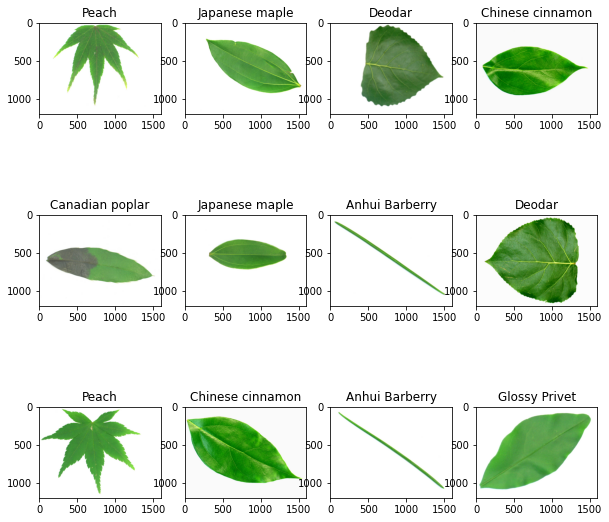

In [8]:
new_size=(256,256)
img_train,label_train, img_test, label_test = LoadData(dataDir,None)
"""
Quelques informations sur les données
"""
print("img for train: %d (Utiliser la création de dictionnaires et la formation)" % (len(img_train)))
print("label for train: %d" % (len(label_train)))

print("images pour le test: %d" % (len(img_test)))
print("label pour le test: %d" % (len(label_test)))

# Afficher au hasard 12 exemples d'images
idxs = np.random.permutation(len(img_train))
plt.figure(figsize = (10,10))
for i in range(12):  # Prélever au hasard 12 échantillons dans le train
    idx=idxs[i]
    plt.subplot(3,4,i+1)
    plt.imshow(img_train[idx])
    plt.title(classes[label_train[idx]])
plt.show()

## Extraction des caracteristiques

> Calculer les descripteurs SIFT(local), Construire un modèle Bag-of-Word (BoW) avec les données d'entraînement



*  detectAndCompute de l'objet sift renvoie 2 sorties kp et des, kp est une liste contenant les points clés détectés par SIFT, des est un tableau numpy contenant des vecteurs de 128 dimensions len (kp). Nous utiliserons ces descripteurs pour résoudre le problème de classification.




In [9]:
def extract_sift_features(X):
  '''
  La fonction prend en entrée la liste d'images que nous avons construit et renvoie la liste image_descriptors, 
  le pième élément de la liste image_descriptors est une liste contenant
  le descripteur de points clés SIFT correspondant à la pième image de la liste X.
  
  '''
  image_descriptors = []

  # initialiser l'objet SIFT
  sift = cv.xfeatures2d.SIFT_create()
  for i in range(len(X)):
    # Detecter les points clés et calculer les descripteurs associés
      kp, des = sift.detectAndCompute(X[i], None)         
      image_descriptors.append(des)
  return image_descriptors

In [10]:
#Si opencv n'a pas assez de bibliothèques: AttributeError: l'objet 'module' n'a pas d'attribut 'xfeatures2d'
image_descriptors = extract_sift_features(img_train)

In [11]:
print(len(image_descriptors))
print(type(image_descriptors[0][0]))
print((image_descriptors[0].shape))
for i in range(20):
    print('Image {} a {} descripteurs'.format(i, len(image_descriptors[i])))

419
<class 'numpy.ndarray'>
(118, 128)
Image 0 a 118 descripteurs
Image 1 a 225 descripteurs
Image 2 a 313 descripteurs
Image 3 a 150 descripteurs
Image 4 a 316 descripteurs
Image 5 a 365 descripteurs
Image 6 a 291 descripteurs
Image 7 a 205 descripteurs
Image 8 a 285 descripteurs
Image 9 a 248 descripteurs
Image 10 a 183 descripteurs
Image 11 a 494 descripteurs
Image 12 a 253 descripteurs
Image 13 a 121 descripteurs
Image 14 a 320 descripteurs
Image 15 a 133 descripteurs
Image 16 a 221 descripteurs
Image 17 a 143 descripteurs
Image 18 a 208 descripteurs
Image 19 a 588 descripteurs


## Construire un dictionnaire



In [12]:
# construire une liste contenant tous les descripteurs
all_descriptors = []
for descriptors in image_descriptors:
    if descriptors is not None:
        for des in descriptors:
            all_descriptors.append(des)
print('Nombre total de descripteurs: %d' %(len(all_descriptors)))

Nombre total de descripteurs: 491896


In [13]:
def kmeans_bow(all_descriptors, num_clusters):
  ''''
  Prend en entrée une liste de tous les descripteurs des images de l'ensemble X et le nombre de clusters num_clusters,
  en utilisant l'algorithme KMeans de scikit-learn pour regrouper ces descripteurs vectoriels en cluster num_clusters.
  La fonction renvoie une liste centrale de clusters. NB: Cette opération prend beaucoup de temps,
  
  
  '''
  bow_dict = []
  # instancier un kmeans
  kmeans = KMeans(n_clusters=num_clusters).fit(all_descriptors)
  bow_dict = kmeans.cluster_centers_
  return bow_dict

#### L'objet kmeans a une méthode d'ajustement, prend des points de données (la liste all_descriptors) et le vecteur n_clusters qui est le centre des clusters de données. Pour obtenir ces vecteurs, nous utilisons la propriété $ cluster_centers_ $ de l'objet kmeans.

In [14]:
# Enregistrer la liste retournée par la fonction kmeans_bow () dans un fichier binaire pour une utilisation plus facile plus tard
# Car cette opération prend beaucoup de temps.
num_clusters = 94
if not os.path.isfile('bow_dictionary94.pkl'):
    BoW = kmeans_bow(all_descriptors, num_clusters)    
    pickle.dump(BoW, open('bow_dictionary94.pkl', 'wb'))
else:
    BoW = pickle.load(open('bow_dictionary94.pkl', 'rb'))
print(len(BoW))
print(len(BoW[0]))

94
128


## Construire le vecteur de caractéristiques avec le modèle BoW obtenu


In [15]:
from scipy.spatial.distance import cdist

def create_features_bow(image_descriptors, BoW, num_clusters):
  '''
  prend la liste d'entrée image_descriptors, list BoW et num_clusters ci-dessus, retourne la liste X_features
  où le p-ième élément de X_vectors est un vecteur de caractéristiques du modèle BoW correspondant à la p-ième image
  
  '''
  X_features = []
  for i in range(len(image_descriptors)):
      features = np.array([0] * num_clusters) # <=> features=np.zeros(num_clusters,dtype=int)        
      if image_descriptors[i] is not None:
          distance = cdist(image_descriptors[i], BoW)            
          argmin = np.argmin(distance, axis=1)            
          for j in argmin:
              features[j] += 1
      X_features.append(features)
  return X_features

## Créer un ensemble d'entraînement basé sur un dictionnaire

In [16]:
image_descriptors = extract_sift_features(img_train)
X_tr = create_features_bow(image_descriptors, BoW, num_clusters)
X_tr=np.array(X_tr)
Y_tr=np.array(label_train)
print("Données d'entraînement")
print("train data: " + str(X_tr.shape))
print("train label: " + str(Y_tr.shape))

Données d'entraînement
train data: (419, 94)
train label: (419,)


## Créer un ensemble de test basé sur le dictionnaire

In [17]:
image_descriptors = extract_sift_features(img_test)
X_te = create_features_bow(image_descriptors, BoW, num_clusters)
X_te=np.array(X_te)
Y_te=np.array(label_test)
print('Données de test')
print("train data: " + str(X_te.shape))
print("train label: " + str(Y_te.shape))

Données de test
train data: (199, 94)
train label: (199,)


## Construire un modèle de classification SVM basé sur des données nouvellement créées


>  Nous avons créé un vecteur de caractéristiques pour chaque image de l'ensemble de données.

> Construire un modèle de classification SVM





In [19]:
# un objet SVM
svm = sklearn.svm.SVC(kernel="linear", C=0.025)
print(svm)

SVC(C=0.025, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


## Former et tester la précision du modèle


> Fonctions fit, prédire, score, ... de l'objet svm)





### Formation modèle

In [20]:
clf = svm.fit(X_tr, Y_tr)

## Précision

In [22]:
# Ensemble d'entrainement
svm.score(X_tr, Y_tr)

# Ensemble de test
svm.score( X_te, Y_te)

0.9798994974874372

In [23]:
y_pred = svm.predict(X_te)

## Evaluation 



> Matrice de confusion





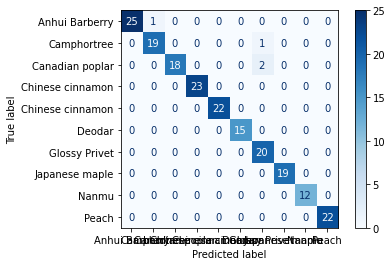

In [24]:
from sklearn.metrics import plot_confusion_matrix
matrix = plot_confusion_matrix(clf, X_te, Y_te, 
                               display_labels=classes,
                                 cmap=plt.cm.Blues,
                                 normalize=None)
#plt.title('Confusion matrix for our classifier')
plt.show(matrix)
plt.show()

## Utilisez un modèle entraîné par pour faire des prédictions sur une image réaliste.

> les étapes:


1. Lire l'image, 
2. Extraire la fonction BoW de l'image
3. Prédire à l'aide du modèle entraîné.


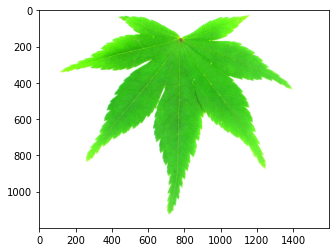

In [26]:
# Étape 1
img = None
img = cv.imread('/content/drive/MyDrive/RV_Flavia/dataset/Japanese maple/1269.jpg')
img=cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()
my_X = [img]

In [27]:
# Étape 2
my_image_descriptors = None
my_X_features = None
my_image_descriptors = extract_sift_features(my_X)
my_X_features = create_features_bow(my_image_descriptors, BoW, num_clusters)
print(len(my_image_descriptors))
print(my_image_descriptors[0].shape)
print(my_X_features[0].shape)
print(my_X_features[0])

1
(1178, 128)
(94,)
[56  5  0 14  4  0  6  6  8  5  1 42  1  4  0 14 11  6 15  1  0 36 19 53
  3 26 66  3  1  6  1  1  1 47 64  8  2  2  2  4 48  3  0  2  0 17 18  0
 42  0  5  2 13  7  0  5 30  4  0  7  0 39  0  0  1  4 99 61 25  1  2  1
  1  1  1  1  4 20  7  0 11  2 58  4 16  3  7  0  2  3  9 15  6 27]


In [28]:
# Étape 3
y_pred = None
y_pred = svm.predict(my_X_features)
print(y_pred)
print("Type:" + classes[y_pred[0]])

[9]
Type:Peach
